# Download data

Here we will use Kaggle's [Car License Plate Detection](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection?datasetId=686454&sortBy=voteCount) dataset that contains $433$ images with bounding box annotations of the car license plates within the image.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sargisiskandaryan","key":"ea135dd349895ca9c4c3d9dfec6677d9"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
#!mkdir .kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection -p /content/car-plate-detection/ --unzip

 95% 193M/203M [00:02<00:00, 51.9MB/s]
100% 203M/203M [00:02<00:00, 80.9MB/s]


# Data preparation

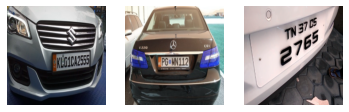

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt

main_path = '/content/car-plate-detection'
img_dir = os.path.join(main_path, 'images')
img_paths = os.path.join(img_dir, '*png')
files = glob.glob(img_paths)
files.sort()

IMG_SIZE = 224
X = []
for file in files:
  img = cv2.imread(file)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  X.append(img)

for i in range(3):
  plt.subplot(1, 3, i + 1)
  plt.axis('off')
  plt.imshow(X[i])

In [ ]:
 with open('/content/car-plate-detection/annotations/Cars0.xml', 'r') as f:
   data = f.read()
   print(data)


<annotation>
    <folder>images</folder>
    <filename>Cars0.png</filename>
    <size>
        <width>500</width>
        <height>268</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>226</xmin>
            <ymin>125</ymin>
            <xmax>419</xmax>
            <ymax>173</ymax>
        </bndbox>
    </object>
</annotation>


In [ ]:
def annotation_resize(file):
  with open(file, 'r') as f:
     data = f.read()
     bs_data = BeautifulSoup(data, 'xml')
     width = int(bs_data.find('width').text)
     height = int(bs_data.find('height').text)
     
     new_xmin = int(bs_data.find('xmin').text) / (width / IMG_SIZE)
     new_xmax = int(bs_data.find('xmax').text) / (width / IMG_SIZE)
     new_ymin = int(bs_data.find('ymin').text) / (height / IMG_SIZE)
     new_ymax = int(bs_data.find('ymax').text) / (height / IMG_SIZE)
  return [int(new_xmax), int(new_ymax), int(new_xmin), int(new_ymin)]

In [ ]:
for i in os.walk('/content/car-plate-detection/annotations'):
  print(i)

('/content/car-plate-detection/annotations', [], ['Cars150.xml', 'Cars81.xml', 'Cars10.xml', 'Cars402.xml', 'Cars88.xml', 'Cars86.xml', 'Cars33.xml', 'Cars170.xml', 'Cars376.xml', 'Cars230.xml', 'Cars335.xml', 'Cars240.xml', 'Cars189.xml', 'Cars66.xml', 'Cars406.xml', 'Cars111.xml', 'Cars143.xml', 'Cars144.xml', 'Cars245.xml', 'Cars79.xml', 'Cars275.xml', 'Cars418.xml', 'Cars146.xml', 'Cars234.xml', 'Cars167.xml', 'Cars392.xml', 'Cars102.xml', 'Cars310.xml', 'Cars133.xml', 'Cars373.xml', 'Cars179.xml', 'Cars315.xml', 'Cars39.xml', 'Cars389.xml', 'Cars174.xml', 'Cars293.xml', 'Cars302.xml', 'Cars404.xml', 'Cars391.xml', 'Cars401.xml', 'Cars16.xml', 'Cars300.xml', 'Cars38.xml', 'Cars62.xml', 'Cars41.xml', 'Cars225.xml', 'Cars258.xml', 'Cars145.xml', 'Cars156.xml', 'Cars93.xml', 'Cars322.xml', 'Cars154.xml', 'Cars247.xml', 'Cars274.xml', 'Cars282.xml', 'Cars306.xml', 'Cars320.xml', 'Cars284.xml', 'Cars125.xml', 'Cars201.xml', 'Cars71.xml', 'Cars361.xml', 'Cars36.xml', 'Cars250.xml', 'Cars

In [ ]:
annot = glob.glob('/content/car-plate-detection/annotations/*xml')
annot.sort()

In [ ]:
y = []
for a in annot:
  y.append(annotation_resize(a))

(-0.5, 223.5, 223.5, -0.5)

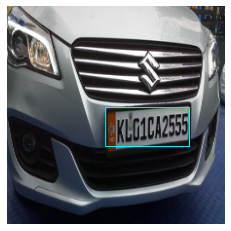

In [ ]:
my_img = cv2.rectangle(X[0], (y[0][0], y[0][1]), (y[0][2], y[0][3]), (0, 255, 255))
plt.imshow(my_img)
plt.axis('off')

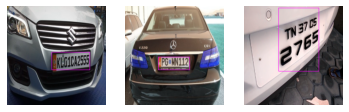

In [ ]:
for i in range(3):
  plt.subplot(1, 3, i + 1)
  my_img = cv2.rectangle(X[i], (y[i][0], y[i][1]),
                               (y[i][2], y[i][3]), (255, 0, 255))
  plt.imshow(my_img)
  plt.axis('off')

In [ ]:
import numpy as np

X = np.array(X) / 255
y = np.array(y) / 255

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

# Model training

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers


#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = models.Sequential()
		# CONV => RELU => POOL
		model.add(layers.Convolution2D(20, (5, 5), activation='relu',
			input_shape=input_shape))
		model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(layers.Convolution2D(50, (5, 5), activation='relu'))
		model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# Flatten => RELU layers
		model.add(layers.Flatten())
		model.add(layers.Dense(500, activation='relu'))
		# a softmax classifier
		model.add(layers.Dense(classes, activation="sigmoid"))
		return model

model = LeNet.build((IMG_SIZE, IMG_SIZE, 3), 4)
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, 
                  validation_data=(X_val, y_val), 
                  epochs=50, batch_size=32, verbose=1)
scores = model.evaluate(X_test, y_test)
print(scores)
y_pred = model.predict(X_test)

Epoch 1/50
9/9 [==============================] - 13s 151ms/step - loss: 0.1974 - accuracy: 0.5109 - val_loss: 0.2316 - val_accuracy: 0.4571
Epoch 2/50
9/9 [==============================] - 1s 68ms/step - loss: 0.2411 - accuracy: 0.4601 - val_loss: 0.2849 - val_accuracy: 0.0000e+00
Epoch 3/50
9/9 [==============================] - 1s 69ms/step - loss: 0.2753 - accuracy: 0.0000e+00 - val_loss: 0.2848 - val_accuracy: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 1s 69ms/step - loss: 0.2632 - accuracy: 0.0000e+00 - val_loss: 0.2522 - val_accuracy: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 1s 68ms/step - loss: 0.1585 - accuracy: 0.0000e+00 - val_loss: 0.0327 - val_accuracy: 0.0000e+00
Epoch 6/50
9/9 [==============================] - 1s 68ms/step - loss: 0.0280 - accuracy: 0.3804 - val_loss: 0.0220 - val_accuracy: 0.4571
Epoch 7/50
9/9 [==============================] - 1s 69ms/step - loss: 0.0210 - accuracy: 0.6123 - val_loss: 0.0201 - val_accuracy: 0.47

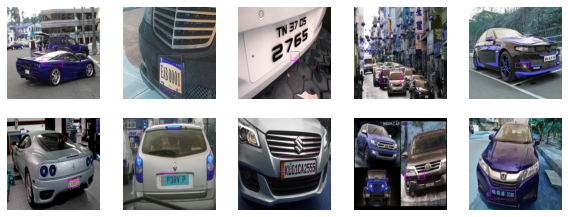

In [ ]:
plt.figure(figsize=(10, 20))
for i in range(10):
  plt.subplot(10, 5, i + 1)
  plt.axis('off')
  annotation = y_pred[i] * 255
  image = cv2.rectangle(X_test[i], (int(annotation[0]), int(annotation[1])),
                        (int(annotation[2]), int(annotation[3])), (255, 0 , 255))
  plt.imshow(image)